# Biomex Data Scientist Coding Test
Please complete the test by adding your code into the cells below. Use whatever python imports you like - but please submit your solution together with enough details of the environment used to enable reproduction of your results (eg, a requirements file). You are encouraged to comment your work throughout so that your intentions are clear. Submissions will be graded according to:

- __Functionality__.Your code is expected to work but evaluation will be largely qualitative. You are not expected to spend time finetuning hyperparameters; the overall fidelity of your models will be disregarded.
- __Efficiency__. The dataset provided is small, for convenience, but your implementation should be scalable to large datasets
- __Code clarity__ and __portability__

## Background

<figure>&nbsp;
<img src="img/schema.jpg" alt="Drawing" style="width: 600px;"/>&nbsp;
<figcaption align = "center"> Fig 1: Schematic illustrating real time control loop. IMU = Inertial Measurement Unit; FES = Functional Electrical Stimulation; 'control unit' = machine learning model </figcaption>
</figure> &nbsp;

The BioStim device incorporates motion sensors, an embedded machine learning model and electrodes into a wearable device, providing a platform for the modification of the muscle contractions of a patient in real time during rehabilitation. Motion data, sampled at 500Hz, form a continuous stream of input to the onboard ML model which generates, for every new sample, a scalar integer output corresponding to the current gait phase of the patient, _p_. _p_ is used to determine the onset and offset of neuromuscular stimulation.

<figure>&nbsp;
<img src="img/gc.png" alt="Drawing" style="width: 600px;"/>&nbsp;
<figcaption align = "center"> Fig 2: Gait cycle defined with reference to the right (red) limb</figcaption>
</figure>

The gait cycle is defined with reference to a given limb - left or right - and comprises stance phase (from the moment of heelstrike to the moment of toe-off) and swing phase (from toe-off to subsequent heelstrike); see Fig. 2. We further subdivide stance and swing into 6 phases, giving 12 phases in total so that the gait phase _p_ lies in the interval $(0, 11)$.  The phases are numbered consecutively from the start of stance to the end of swing. Phases 0-5 inclusive make up stance, with phase 0 representing the period immediately following heel-strike. Phases 6-11 make up swing, with phase 11 representing the period immediately preceding heelstrike. Your modelling task is to predict this scalar integer using the sensor data as input. That is, using _any_ of the sensor data available up to and including (but not beyond) time _t_, predict the gait phase at time _t_.  

### Data format
The dataset comprises 6 CSV files, taken from 5 subjects. Filenames are provided in the format 'ID_ACTIVITY.csv' where ID is a three digit subject identifier and ACTIVITY denotes the activity recorded; 'walk' = walking, 'jog' = jogging, 'var' = various. All recordings were taken at 500Hz. Note that a broad range of different walking and running speeds is represented. Each CSV represents a single contiguous recording with the arrow of time running from top to bottom. Each row represents the data sampled at a given timepoint - the interval between successive rows is 1000/500 = 2ms. 

#### Features 
Features are recorded from two motion sensors embedded in the device. Left and right are defined from the subject's point of view. Linear accelerations are given in $m/s^2$; angular velocities are in $degrees/s$.

- _acc_x_left_: x-component of linear acceleration from left sensor
- _acc_y_left_: y-component of linear acceleration from left sensor
- _acc_z_left_: z-component of linear acceleration from left sensor
- _gyr_x_left_: x-component of angular velocity from left sensor
- _gyr_y_left_: y-component of angular velocity from left sensor
- _gyr_z_left_: z-component of angular velocity from left sensor

- _acc_x_right_: x-component of linear acceleration from right sensor
- _acc_y_right_: y-component of linear acceleration from right sensor
- _acc_z_right_: z-component of linear acceleration from right sensor
- _gyr_x_right_: x-component of angular velocity from right sensor
- _gyr_y_right_: y-component of angular velocity from right sensor
- _gyr_z_right_: z-component of angular velocity from right sensor

#### Label
_left_phase_: Integer in the interval $(0, 11)$ corresponding to the gait phase of the left leg of the subject. Data for the right leg are not provided.


### Constraints
In the embedded environment, severe constraints exist on available compute and memory. For the purposes of this exercise, you may disregard these constraints.

### Additional background
Please see the attached _Addendum.pdf_ for additional information.

## 1. Data exploration [10 points]
Perform a basic exploratory analysis of the data, producing plots to illustrate any findings of interest. Focus on feature selection, which in this context includes historical features: recall that to predict the gait phase at time _t_, you may use any of the data available up to and including time _t_.

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
#np.object = object
#np.bool = bool
#np.int = int
np.typeDict = dict()
import matplotlib.pyplot as plt

from scipy import fftpack
from scipy.signal import butter,filtfilt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tsgm

pd.pandas.set_option('display.max_columns', None)

2023-12-10 21:44:53.523344: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 21:44:53.834289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 21:44:53.834426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 21:44:53.889963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 21:44:54.104403: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 21:44:54.108656: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Load the data:
data_folder_path = 'data'
filenames = [ data_folder_path+'/'+name for name in os.listdir(data_folder_path)]
data_list = [pd.read_csv(file) for file in filenames]

In [3]:
# Print a few rows as example:
data_list[0].head(2)

,Unnamed: 0,acc_x_left,acc_y_left,acc_z_left,gyr_x_left,gyr_y_left,gyr_z_left,acc_x_right,acc_y_right,acc_z_right,gyr_x_right,gyr_y_right,gyr_z_right,left_phase
0,0,5.321637,-3.081956,-3.713661,-7.75,23.3125,22.25,13.064811,3.407379,-2.880958,-43.6875,90.3750,156.0,7
1,1,5.551348,-3.665804,-3.684947,-7.75,23.3125,22.25,13.189238,3.273381,-3.091527,-50.8750,88.1875,157.0,7


In [4]:
data_list[2].head(2)

,Unnamed: 0,acc_x_left,acc_y_left,acc_z_left,gyr_x_left,gyr_y_left,gyr_z_left,acc_x_right,acc_y_right,acc_z_right,gyr_x_right,gyr_y_right,gyr_z_right,left_phase
0,0,10.317851,-3.656233,-2.143969,7.5625,38.0625,91.8750,15.237494,2.478964,-0.315853,-147.1875,84.9375,170.3125,7
1,1,9.934999,-3.340380,-2.861816,12.7500,31.4375,95.6875,15.649060,2.967100,-0.248854,-152.5625,85.1250,169.9375,7


In [5]:
# Check dataframes dimensions:
for df in data_list:
    df.drop('Unnamed: 0', axis=1, inplace=True)
    print(df.shape)

(100000, 13)
(100000, 13)
(74407, 13)
(100000, 13)
(19007, 13)
(100000, 13)


Number of labels: 12


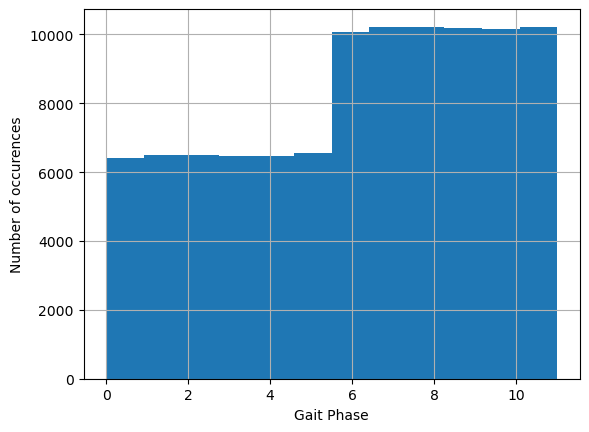

Number of labels: 12


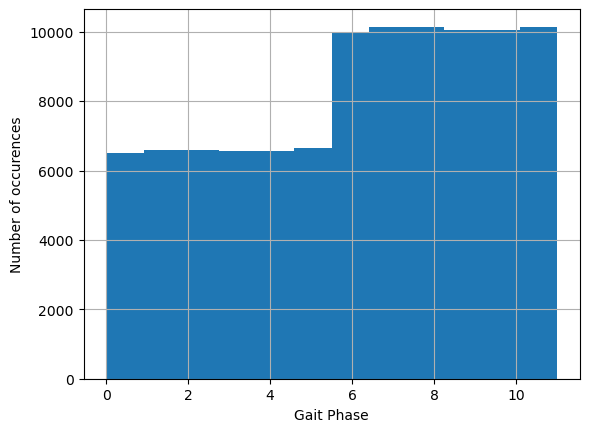

Number of labels: 12


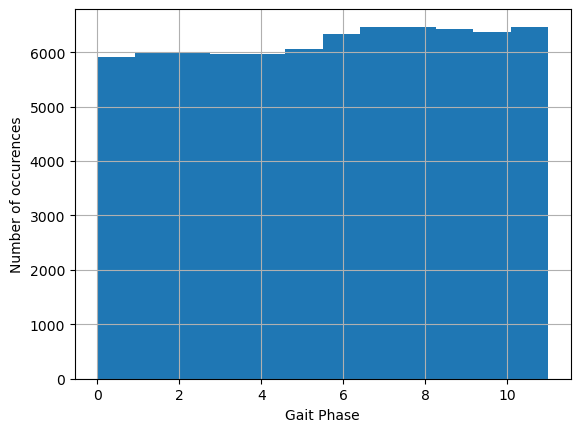

Number of labels: 12


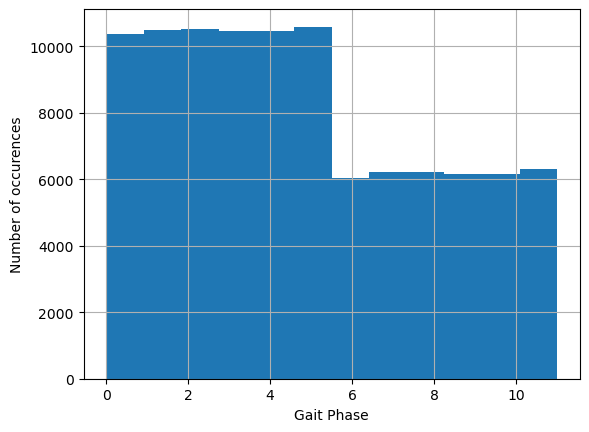

Number of labels: 12


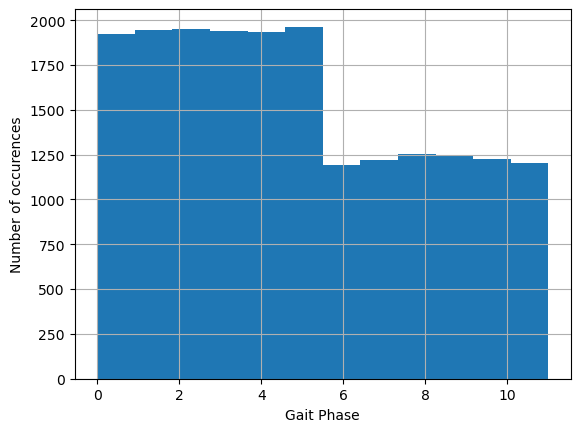

Number of labels: 12


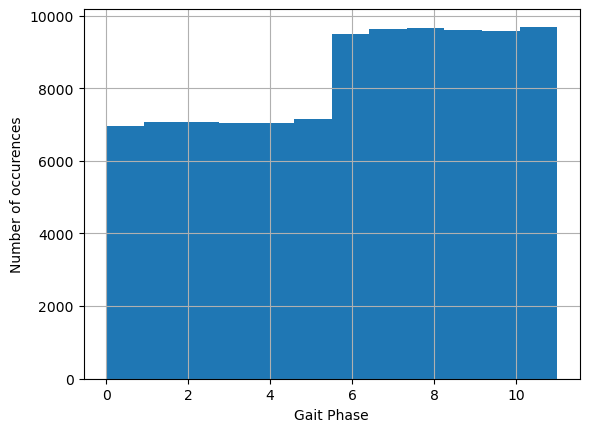

In [6]:
# Check labels distribution:
for df in data_list:
    n_labels = df['left_phase'].unique().shape[0]
    print(f'Number of labels: {n_labels}')
    df['left_phase'].hist(bins=n_labels, density=False)
    plt.ylabel('Number of occurences')
    plt.xlabel('Gait Phase')
    plt.show()

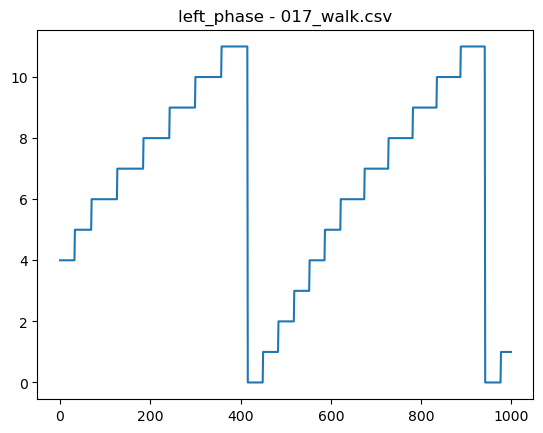

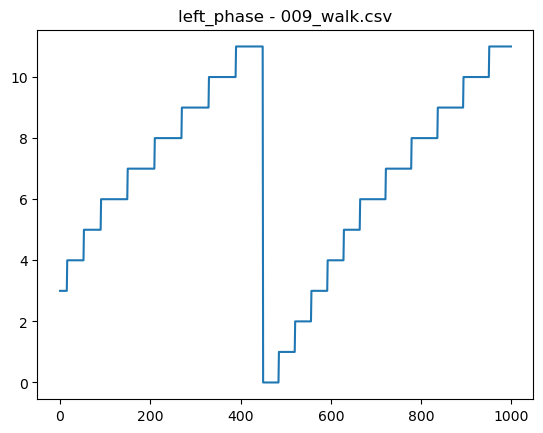

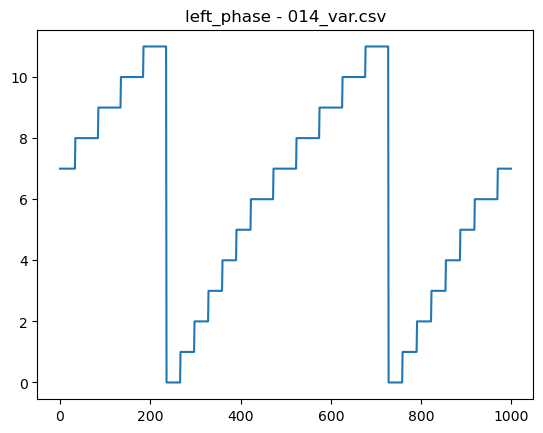

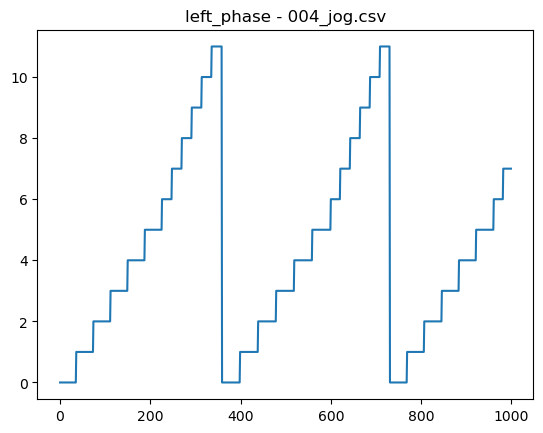

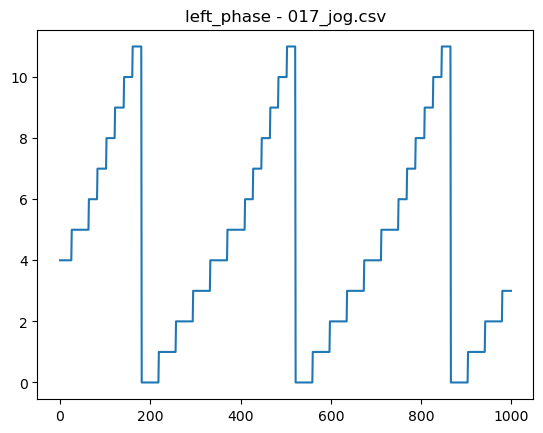

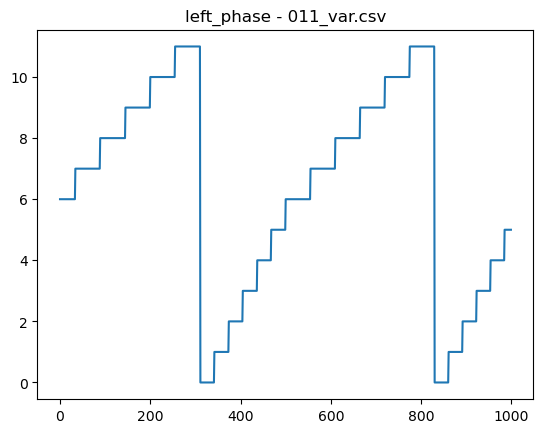

In [7]:
# Check labels period of label occurrence: 
for index, df in enumerate(data_list):
    labels = df['left_phase'].to_numpy()
    fig, ax = plt.subplots()
    ax.plot(labels[1000:2000])
    plt.title(f'left_phase - {filenames[index][5:]}')
    plt.show()

### Signal period for walking subjects is around 600 samples, and it reduces to around 300 samples for jogging subjects. This is useful also to gauge the duration of each gait phase.

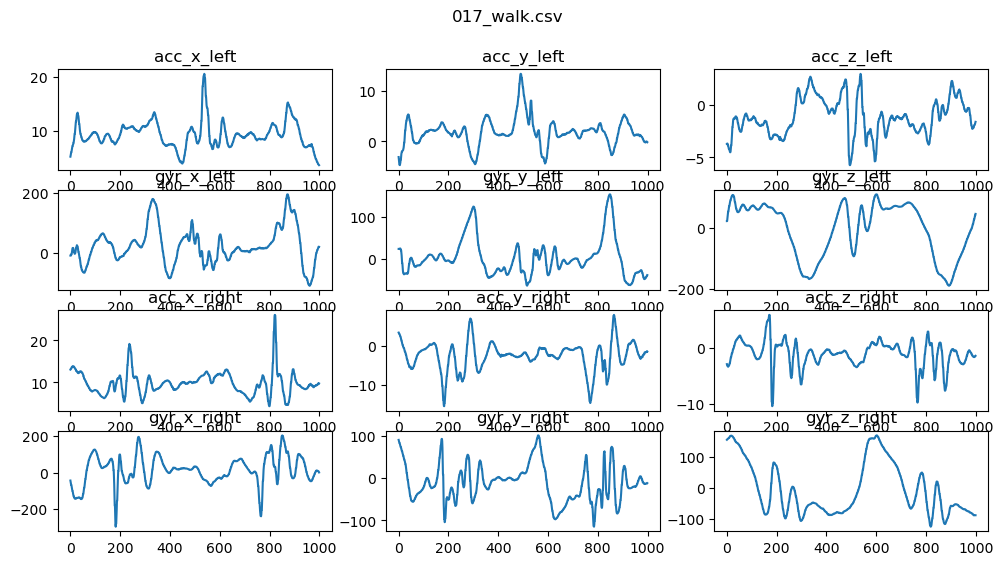

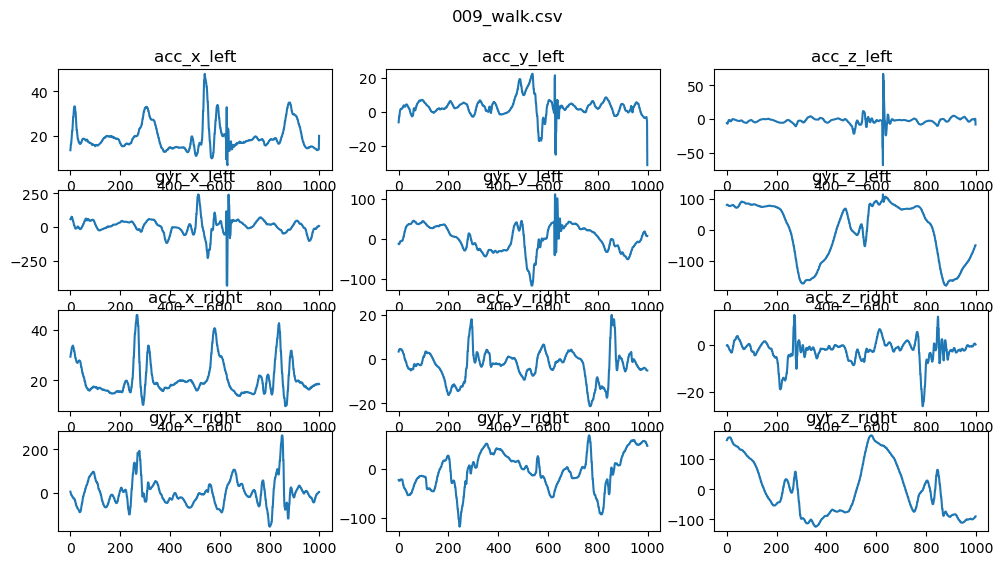

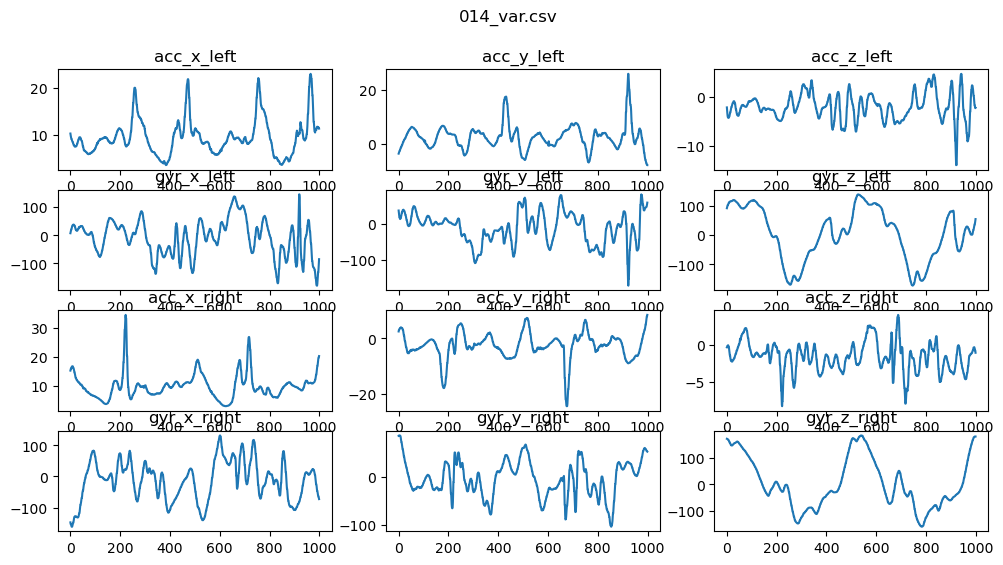

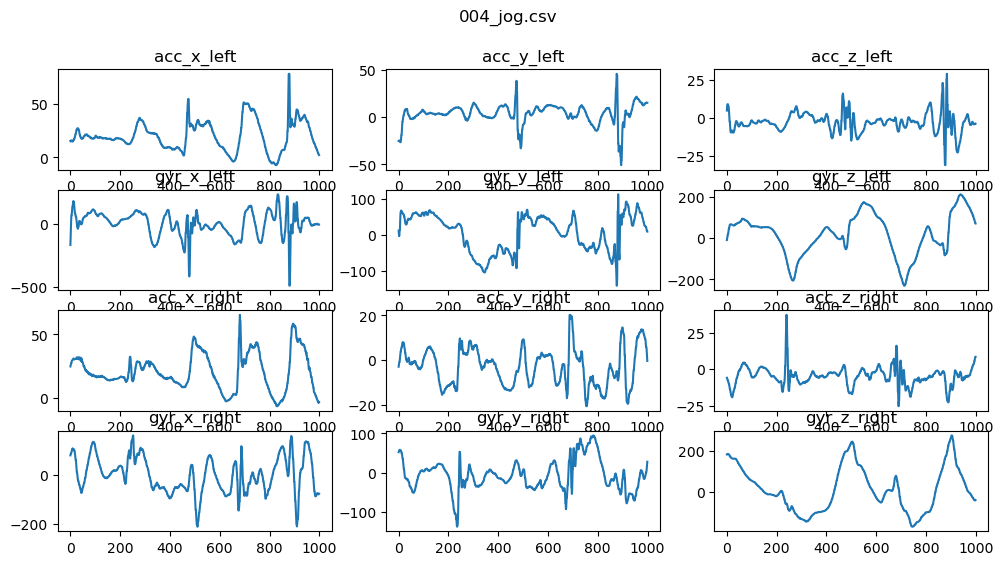

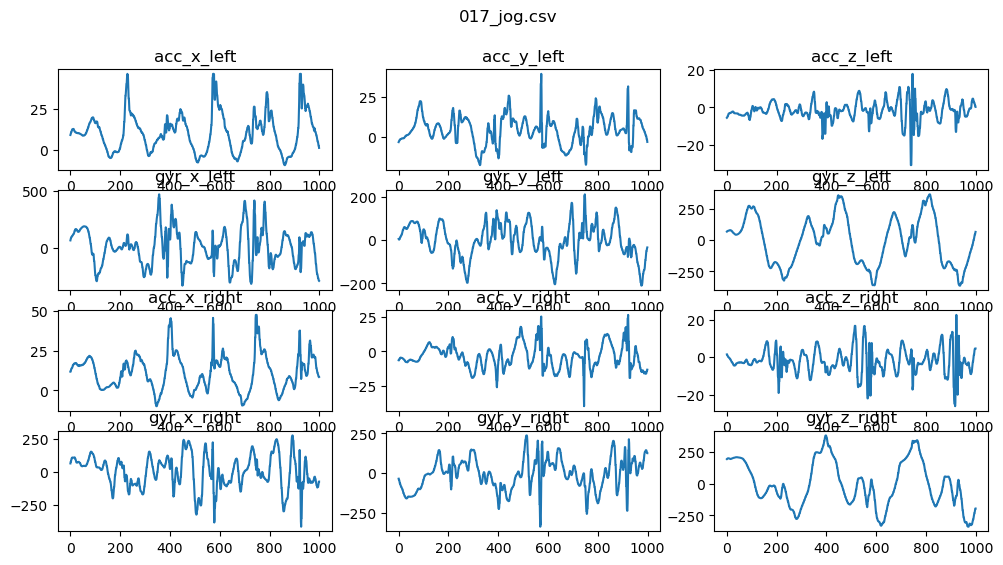

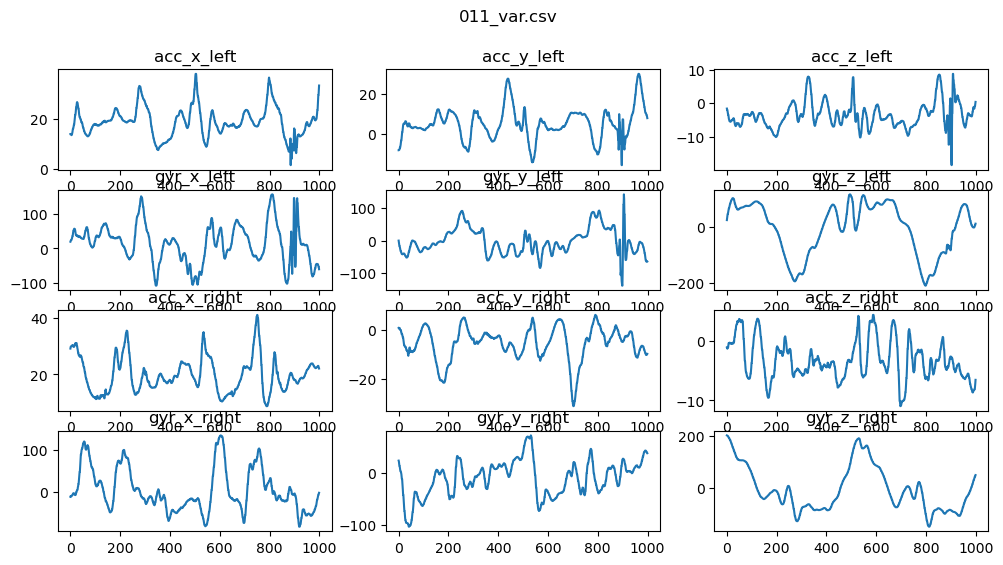

In [8]:
# Plotting 1000 time stamps (2 seconds) of every feature of every subject:
for id, df in enumerate(data_list):
    features = df.columns
    nrows = 4
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, figsize=[12,6])
    feat_count = 0
    for i in range(nrows):
        for j in range(ncols):
            ax[i,j].plot(df[features[feat_count]][0:1000])
            ax[i,j].set_title(features[feat_count])
            feat_count += 1
    plt.suptitle(f'{filenames[id][5:]}')
    plt.show()

Cutoff freq 7
(100000,) (100000,)


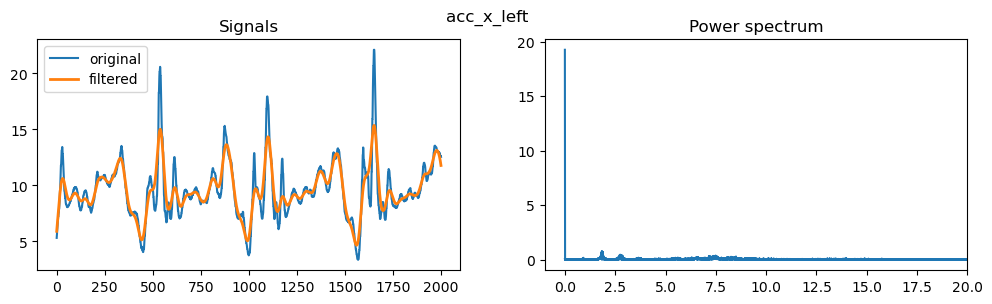

Cutoff freq 7
(100000,) (100000,)


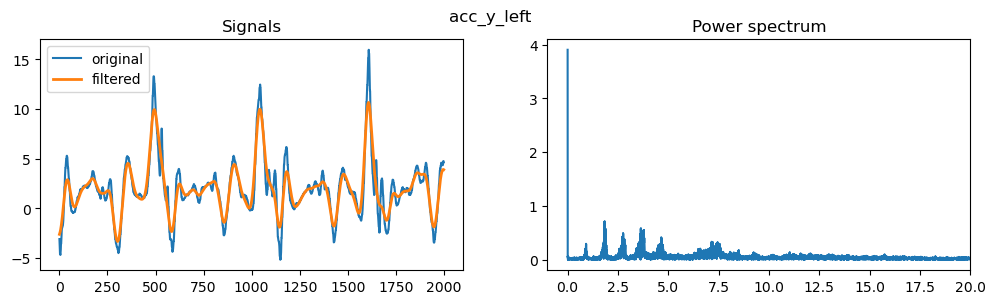

Cutoff freq 7
(100000,) (100000,)


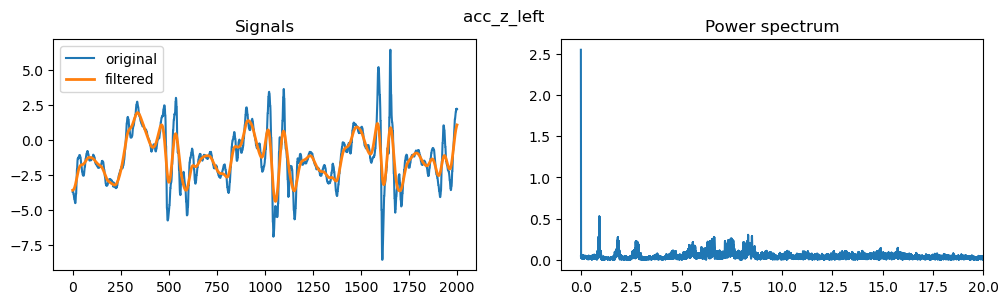

Cutoff freq 7
(100000,) (100000,)


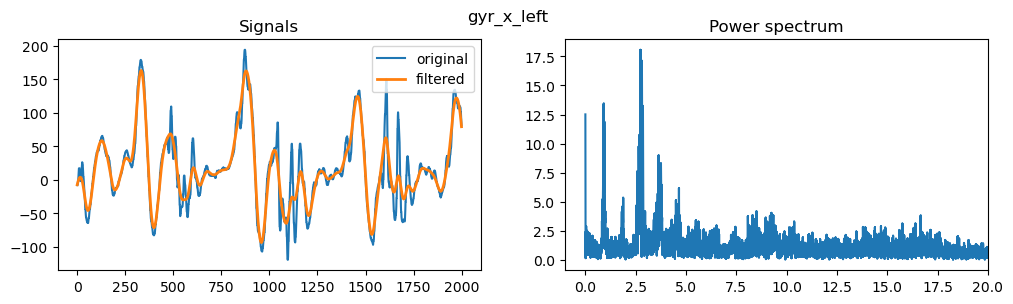

Cutoff freq 7
(100000,) (100000,)


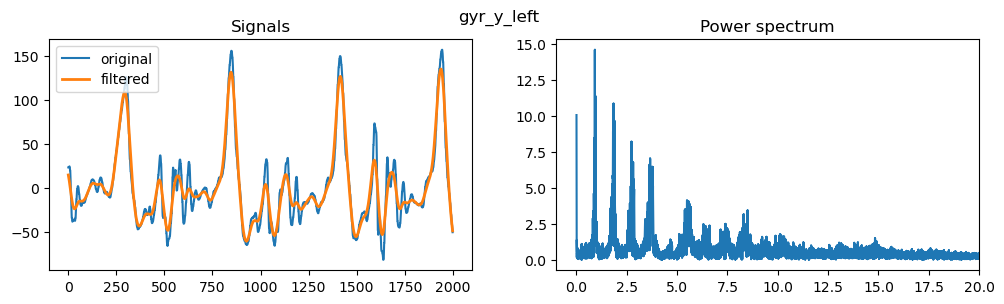

Cutoff freq 7
(100000,) (100000,)


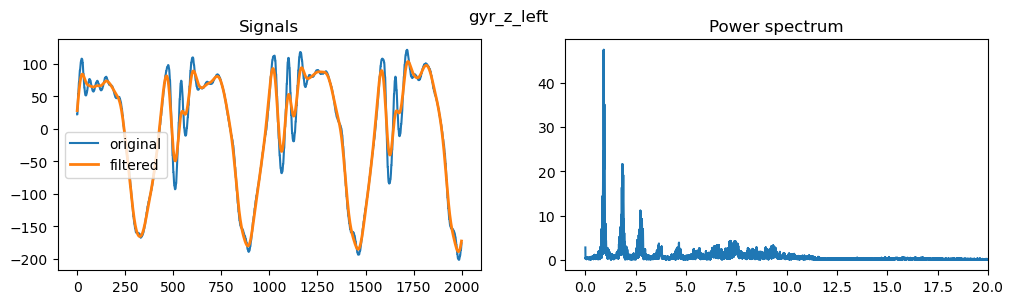

Cutoff freq 7
(100000,) (100000,)


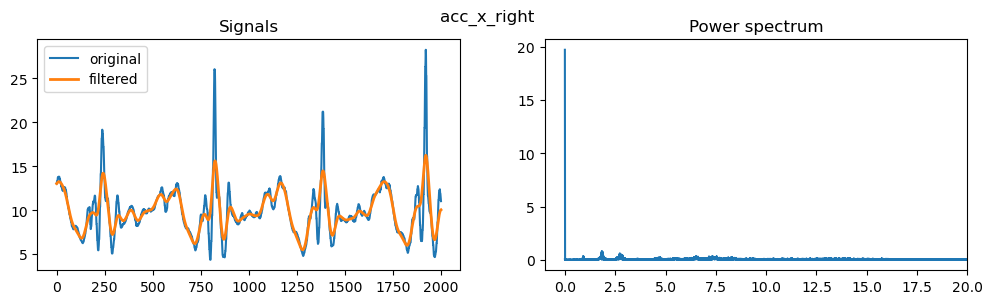

Cutoff freq 7
(100000,) (100000,)


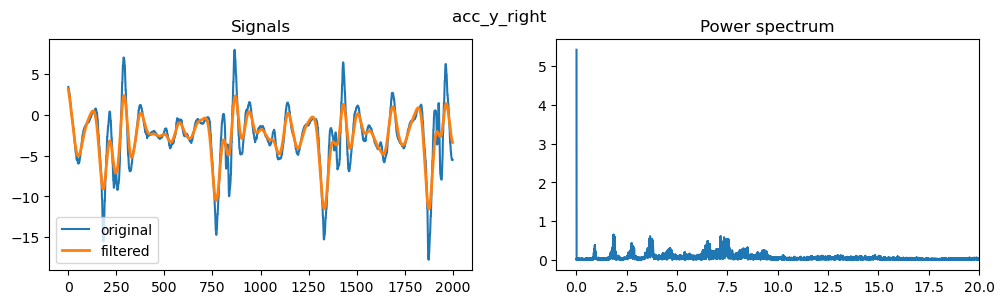

Cutoff freq 7
(100000,) (100000,)


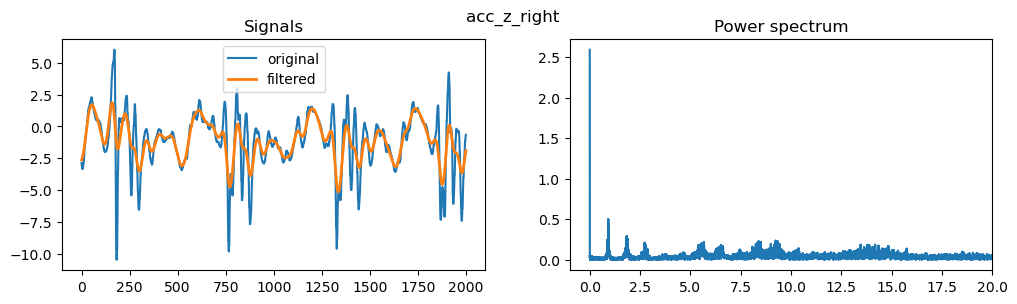

Cutoff freq 7
(100000,) (100000,)


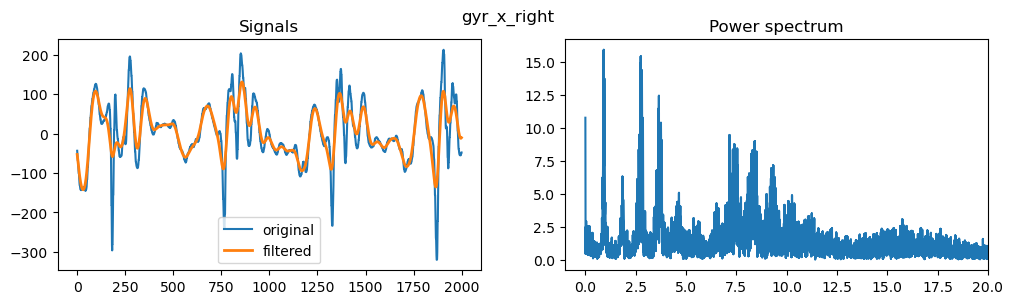

Cutoff freq 7
(100000,) (100000,)


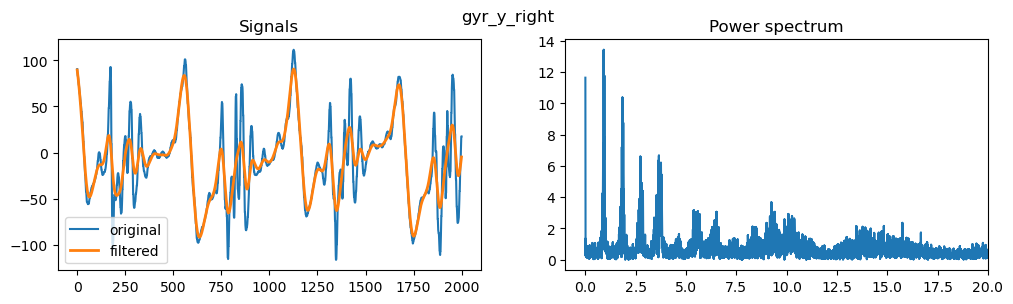

Cutoff freq 7
(100000,) (100000,)


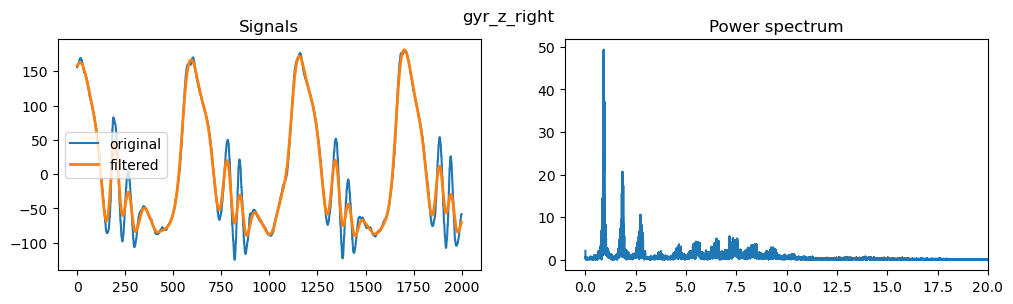

In [9]:
# Check if low pass frenquency filter can smooth out the signals:

# Taking the first subject as example:
data = data_list[0]
data.drop('left_phase', axis=1, inplace=True)

freq = 500 # Hz
sec = int( data.shape[0] / freq )
time = np.linspace(0, sec, data.shape[0], endpoint=True)


for feat in data.columns:

    signal = data[feat].to_numpy()

    sig_noise_fft = fftpack.fft(signal)
    sig_noise_amp = 2 / time.size * np.abs(sig_noise_fft)
    sig_noise_freq = np.abs(fftpack.fftfreq(time.size, 1/freq))
    
    fs = freq       # sample rate, Hz
    cutoff = 7   # desired cutoff frequency of the filter, Hz , based on visual inspection of the power spectrums
    order = 2       
    def butter_lowpass_filter(data, cutoff, fs, order):
        print("Cutoff freq " + str(cutoff))
        nyq = 0.5 * fs # Nyquist Frequency
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients 
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a,data)
        return y
    # Filter the data, and plot filtered signals.
    y = butter_lowpass_filter(signal, cutoff, fs, order)

    print(signal.shape, y.shape)
    
    fig, ax = plt.subplots(1,2, figsize=[12,3])
    ax[0].plot(signal[:2000], label='original')
    ax[0].plot(y[:2000], linewidth=2, label='filtered')
    ax[0].set_title('Signals')
    ax[0].legend()
    ax[1].plot(sig_noise_freq, sig_noise_amp)
    ax[1].set_xlim([-1,20])
    ax[1].set_title('Power spectrum')
    plt.suptitle(feat)
    plt.show()

## 2. Data ingestion [30 points]
Write a function which takes a single argument - a list of strings corresponding to CSV file names - and returns  an appropriate iterator object or other dataset abstraction. This object should generate tuples (or some other appropriate data structure) containing batches of input data samples taken from the relevant CSV files, ready for input to your model, and corresponding batches of labels. The labels should be one-hot encoded. If you opt to include historical features, you may drop those samples at the start of the sessions for which full data do not exist. In writing your function you should consider:

- Dimensionality, which should be suitable for your planned model
- The features to be included 
- Any preprocessing


#### The function below loads the data and splits the subjects randomly in train/test. I have chosen 0.8% of the subjects being part of the training data and 0.2% of the test data, so in this case the data of 4 subjects are used as training and the data of 2 subjects are used as test. A series of pre-processing operations are then performed, following the exploration in point 1: frequency filtering, scaling, one-hot encoding of the labels, etc.. The function outputs 4 numpy arrays (X_train, y_train, X_test and y_test) in the right format to be used by the model selected, which will be a simple Long-Short-Term Memory neural network. 

In [10]:
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a,data)
    return y

In [11]:
data_folder_path = 'data'
filenames = [ data_folder_path+'/'+name for name in os.listdir(data_folder_path)]

def make_dataset(filenames):
    
    """your code here"""

    # Randomly split patients in training and test:
    n_of_patients = len(filenames)
    TRAIN_TEST_SPLIT = 0.8
    patients_training = int(n_of_patients*TRAIN_TEST_SPLIT)
    filenames_train = filenames[:patients_training]
    filenames_test = filenames[patients_training:]

    # Hard-coded train-test splits:
    
    # Split based on type of experiment:
    #filenames_train = [subject for subject in filenames if subject.lower()[9:12]  == 'var']
    #filenames_test = [subject for subject in filenames if subject.lower()[9:12]  == 'jog' or subject.lower()[9:13]  == 'walk']

    # Fully hard-coded split:
    #filenames_train = ['data/017_walk.csv', 'data/009_walk.csv', 'data/014_var.csv', 'data/004_jog.csv', 'data/017_jog.csv']
    #filenames_test = ['data/011_var.csv']
    
    # Load training and test patients data:
    df_train = pd.concat( pd.read_csv(file) for file in filenames_train )
    df_test = pd.concat( pd.read_csv(file) for file in filenames_test )

    # Separate target variables from features:
    train_labels = df_train['left_phase'].to_numpy()
    df_train.drop('left_phase', axis=1, inplace=True)
    test_labels = df_test['left_phase'].to_numpy()
    df_test.drop('left_phase', axis=1, inplace=True)

    # Labels one-hot encoding:
    train_labels_encoded = to_categorical(train_labels)
    test_labels_encoded = to_categorical(test_labels)
    n_classes = train_labels_encoded.shape[1]

    # Drop first column:
    df_train.drop('Unnamed: 0', axis=1, inplace=True)
    df_test.drop('Unnamed: 0', axis=1, inplace=True)

    # Frequency filtering:
    fs = 500 # Hz
    sec = int( df_train.shape[0] / fs )
    time = np.linspace(0, sec, df_train.shape[0], endpoint=True)
    cutoff = 7   # desired cutoff frequency of the filter, Hz 
    order = 2       # quadratic order

    for feat in df_train.columns:

        # Training data:
        signal = df_train[feat].to_numpy()
        sig_noise_fft = fftpack.fft(signal)
        sig_noise_amp = 2 / time.size * np.abs(sig_noise_fft)
        sig_noise_freq = np.abs(fftpack.fftfreq(time.size, 1/fs))
        # Filter the data:
        y = butter_lowpass_filter(signal, cutoff, fs, order)
        df_train[feat] = y

        # Test data:
        signal = df_test[feat].to_numpy()
        sig_noise_fft = fftpack.fft(signal)
        sig_noise_amp = 2 / time.size * np.abs(sig_noise_fft)
        sig_noise_freq = np.abs(fftpack.fftfreq(time.size, 1/fs))
        # Filter the data:
        y = butter_lowpass_filter(signal, cutoff, fs, order)
        df_test[feat] = y
         
    # Convert dataframes to 2D numpy array:
    np_train = np.array(df_train)
    np_test = np.array(df_test)

    ## Scaling:
    scaler = StandardScaler()
    scaler.fit(np_train)
    np_train = scaler.transform(np_train)
    np_test = scaler.transform(np_test)

    # Split the data in windows:
    n_rows_train = np_train.shape[0]
    n_rows_test = np_test.shape[0]
    # rows per window: 60 = 0.125 seconds. Based on the pre-processing, this is about the average gate phase duration. 
    m = 60 
    overlap = 10
    total_windows_train = int( n_rows_train / (m - overlap) ) - 1
    total_windows_test = int( n_rows_test / (m - overlap) ) - 1

    # Reshaping the 2D numpy array in a 3D array, with [windows,samples_per_windows,features] as dimensions:
    # For training data:
    lx = []
    ly = []
    for w in range(total_windows_train):
        if w == 0:
            lx.append(np_train[w*m:w*m+m,:])
            ly.append(train_labels_encoded[w*m:w*m+m,:])
        else:
            lx.append(np_train[w*m-w*overlap:w*m+m-w*overlap,:])
            ly.append(train_labels_encoded[w*m-w*overlap:w*m+m-w*overlap,:])
    X_train = np.array(lx)
    train_labels_encoded_reshaped = np.array(ly)
    # For test data:
    lx = []
    ly = []
    for w in range(total_windows_test):
        if w == 0:
            lx.append(np_test[w*m:w*m+m,:])
            ly.append(test_labels_encoded[w*m:w*m+m,:])
        else:
            lx.append(np_test[w*m-w*overlap:w*m+m-w*overlap,:])
            ly.append(test_labels_encoded[w*m-w*overlap:w*m+m-w*overlap,:])
    X_test = np.array(lx)
    test_labels_encoded_reshaped = np.array(ly)

    # We need one label per window:
    # For training data:
    y_train = np.zeros((train_labels_encoded_reshaped.shape[0],train_labels_encoded_reshaped.shape[2]))
    for i in range(train_labels_encoded_reshaped.shape[0]):
        decoded_labels = np.argmax(train_labels_encoded_reshaped[i,:,:], axis=1)
        most_common_label = np.argmax(np.bincount(decoded_labels)) # We use the most common label to label the window.
        mcl_encoded = to_categorical(most_common_label,num_classes=12)
        y_train[i,:] = mcl_encoded 
    # For test data:
    y_test = np.zeros((test_labels_encoded_reshaped.shape[0],test_labels_encoded_reshaped.shape[2]))
    for i in range(test_labels_encoded_reshaped.shape[0]):
        decoded_labels = np.argmax(test_labels_encoded_reshaped[i,:,:], axis=1)
        most_common_label = np.argmax(np.bincount(decoded_labels)) # We use the most common label to label the window.
        mcl_encoded = to_categorical(most_common_label,num_classes=12)
        y_test[i,:] = mcl_encoded
      
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = make_dataset(filenames)

## 3. Data augmentation [10 points]
Data augmentation may be used to induce invariance of model outputs to certain characteristics of the input. Expand the size of the dataset by 100% by using a single type of transformation. Amend your function from (2) to include an additional augmentation step. Additional credit will be given for the appropriateness of the chosen data transformation.

#### I have used the SliceAndShuffle function from the tsgm package to, as the name suggests, slice and shuffle the time series features of the training set, to double the size of the training data.

In [12]:
def make_augmented_dataset(X_train, y_train):
    
    """your code here"""
     # Data augmentation:
    aug_model = tsgm.models.augmentations.SliceAndShuffle()
    # We basically divide each time series in 0.125 seconds segments and we shuffle them around, to create a further n_samples series,
    # which will we stack to the original ones, obtaining a dataset twice as long.
    # For training:
    X_train_synthetic, y_train_synthetic = aug_model.generate(X=X_train, y=y_train, n_samples=X_train.shape[0], n_segments=X_train.shape[1])
    X_train_augmented = np.concatenate([X_train, X_train_synthetic], axis=0)
    y_train_augmented = np.concatenate([y_train, y_train_synthetic], axis=0)

    return X_train_augmented, y_train_augmented,

X_train_augmented, y_train_augmented = make_augmented_dataset(X_train, y_train)

## 4. Model building [20 points]
Define a model architecture appropriate to the modelling task that accepts your dataset samples and outputs an integer corresponding to the estimated gait phase. Write a function that returns this architecture as output. Where appropriate, add comments to justify specific model features.

#### I have quickly built using keras a simple LSTM network, which is a model architecture commonly used for multivariate time series classification tasks

In [13]:
def build_model(n_timesteps,n_features,n_classes):
    
    """your code here"""
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [14]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = y_train.shape[1]
model = build_model(n_timesteps,n_features,n_classes)

## 5. Validation [30 points]
Trained models will be deployed to novel, unseen subjects. Training using a categorical cross-entropy loss and using a validation metric of your choice, implement an appropriate training/ validation routine to provide a high quality estimate of model performance in a population of such subjects. For convenience, you may wish to use one or more of the functions you defined in (2), (3) and (4).

#### In this function the model is trained using the .fit() method and the model is also evaluated by using the .predict() methood on the test set. The predicted label are then used to generate a classification report, a very useful function in the sci-kit learn package, which lets us explore a number of different metrics (accuracy, precision, recall and F1 score). A confusion matrix is also computed, which will help with the visualization

In [15]:
def train_and_validate(model, epochs, batch_size, X_train, y_train, X_test, y_test):
    
    """your code here"""
    # Train LSTM:
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Evaluate LSTM:
    #prova, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    y_pred = model.predict(X_test, batch_size=64, verbose=0)

    # Decode predictions and true labels:
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_test_bool = np.argmax(y_test, axis=1)
    cr = classification_report(y_test_bool, y_pred_bool)

    cm = confusion_matrix(y_test_bool, y_pred_bool)
    
    return cr, cm

#### The cell below calls the train_and_evaluate() function, and displays the classification report and the confusion matrix. Number of epochs, batch_size and whether to use the augmented training data can be specified here.

Epoch 1/20
234/234 [==============================] - 10s 35ms/step - loss: 0.8893 - accuracy: 0.7052
Epoch 2/20
234/234 [==============================] - 7s 31ms/step - loss: 0.4506 - accuracy: 0.8388
Epoch 3/20
234/234 [==============================] - 8s 33ms/step - loss: 0.3523 - accuracy: 0.8668
Epoch 4/20
234/234 [==============================] - 8s 34ms/step - loss: 0.3224 - accuracy: 0.8773
Epoch 5/20
234/234 [==============================] - 8s 34ms/step - loss: 0.3067 - accuracy: 0.8826
Epoch 6/20
234/234 [==============================] - 8s 34ms/step - loss: 0.3167 - accuracy: 0.8761
Epoch 7/20
234/234 [==============================] - 8s 34ms/step - loss: 0.2857 - accuracy: 0.8861
Epoch 8/20
234/234 [==============================] - 9s 39ms/step - loss: 0.2886 - accuracy: 0.8849
Epoch 9/20
234/234 [==============================] - 8s 33ms/step - loss: 0.2720 - accuracy: 0.8922
Epoch 10/20
234/234 [==============================] - 8s 35ms/step - loss: 0.2716 - accur

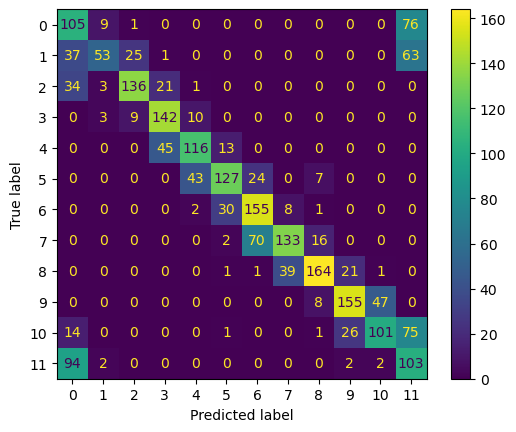

In [17]:
use_augmented_data = False
epochs = 20
batch_size = 32 
if use_augmented_data:
    cr, cm = train_and_validate(model, epochs, batch_size, X_train_augmented, y_train_augmented, X_test, y_test)
else:
    cr, cm = train_and_validate(model, epochs, batch_size, X_train, y_train, X_test, y_test)
# Print classification report:
print(cr)
# Display Confusion Matrix:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## 6. Iteration [20 points]
Your model goes into production. Performance is generally acceptable, but it is soon realised that some of the model's errors are more costly than others. Generally, when the model is wrong, it introduces a timing offset between the desired start or end of stimulation, and the actual start or end of stimulation. The greater the magnitude of this offset, the more costly the error.

Make one or more changes to any aspect of your model, label encoding and/or the training process to better reflect this updated understanding of cost. You may wish to consult the _Addendum.pdf_ to understand how stimulation is determined by the gait phase estimate _p_. Assume that, in expectation, all gait phases are equally likely to be chosen for stimulation. Implement your changes as part of a modified training / validation routine, and add comments so that your changes are clearly indicated.

#### Here, it seems that we want to penalise some errors above others. My reasoning is that the errors that we want to penalise are the ones at the beginning or at the end of the stimulus. I imagined this scenario, as an example. The subject has to be stimulated, say, from gait phase 4 to gait phase 7. By what I gathered, it does not matter massively if, let's say, phase 0 is missclassified, because that phase is not part of the stimulus. On the contrary, the most sensitive classes are 4 and 7, because if the model misses a phase 4, the stimulus will start later, and if it misses a phase 7, the stimulus will end later. Thus, the offset between the desired start or end of stimulation, and the actual start or end of stimulation will increase.

#### For these reasons, I have modified the training of the model, by creating a weighted categorical cross-entropy loss function, which gives different importance to the various classes. During the training of the model, the loss function will be minimized more when the model gets the sensitive classes right. By setting the weights accordingly, we can improve the model performance on the specific classes, in this case 4 and 7, i.e. the classes of start and end of the stimulus (which can be set below along with the epochs and batch_size). The target is to minimize the false negative on those classes, i.e. maximize the recall, as we prioritise not missing the samples which belong to gait phase 4 and 7.

In [18]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):

    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [24]:
def train_and_validate_2(epochs, batch_size, X_train, y_train, X_test, y_test, phase_of_start_stimulus, phase_of_end_stimulus):

    n_timesteps = X_train.shape[1]
    n_features = X_train.shape[2]
    n_classes = y_train.shape[1]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    weights = np.ones((n_classes,))*0.5
    weights[phase_of_start_stimulus] = 10
    weights[phase_of_end_stimulus] = 10

    model.compile(loss=weighted_categorical_crossentropy(weights), optimizer='adam', metrics=['accuracy'])
    """your code here"""
    # Train LSTM:
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Evaluate LSTM:
    #prova, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    y_pred = model.predict(X_test, batch_size=64, verbose=0)

    # Decode predictions and true labels:
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_test_bool = np.argmax(y_test, axis=1)
    cr = classification_report(y_test_bool, y_pred_bool)

    cm = confusion_matrix(y_test_bool, y_pred_bool)
    
    return cr, cm

Epoch 1/10
117/117 [==============================] - 9s 59ms/step - loss: 1.6552 - accuracy: 0.2889
Epoch 2/10
117/117 [==============================] - 7s 60ms/step - loss: 0.5711 - accuracy: 0.6766
Epoch 3/10
117/117 [==============================] - 6s 51ms/step - loss: 0.3950 - accuracy: 0.7792
Epoch 4/10
117/117 [==============================] - 6s 48ms/step - loss: 0.3293 - accuracy: 0.8106
Epoch 5/10
117/117 [==============================] - 6s 55ms/step - loss: 0.3203 - accuracy: 0.8234
Epoch 6/10
117/117 [==============================] - 7s 58ms/step - loss: 0.2975 - accuracy: 0.8309
Epoch 7/10
117/117 [==============================] - 6s 55ms/step - loss: 0.2935 - accuracy: 0.8329
Epoch 8/10
117/117 [==============================] - 7s 64ms/step - loss: 0.2516 - accuracy: 0.8497
Epoch 9/10
117/117 [==============================] - 7s 61ms/step - loss: 0.2633 - accuracy: 0.8435
Epoch 10/10
117/117 [==============================] - 7s 64ms/step - loss: 0.2753 - accura

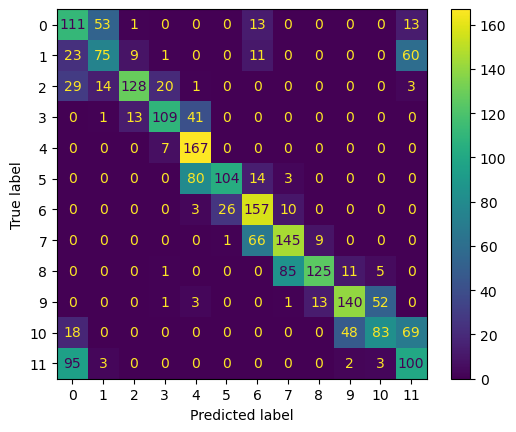

In [25]:
use_augmented_data = False
epochs = 10
batch_size = 64
phase_of_start_stimulus = 4
phase_of_end_stimulus = 7
if use_augmented_data:
    cr, cm = train_and_validate_2(epochs, batch_size, X_train_augmented, y_train_augmented, X_test, 
                                  y_test, phase_of_start_stimulus, phase_of_end_stimulus)
else:
    cr, cm = train_and_validate_2(epochs, batch_size, X_train, y_train, X_test, y_test, phase_of_start_stimulus, phase_of_end_stimulus)
# Print classification report:
print(cr)
# Display Confusion Matrix:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Final considerations:
#### We can see that with the modified loss function the recall for classes 4 and 7 improves (67% to 96% and 60% to 66%).

#### The model overall reaches a 66% accuracy with the normal categorical cross-entropy loss, which is not bad, considering the architecture is quite simple and not hyperparameter tuning was performed. 

#### Beside hyperparameter tuning, more attempts on data pre-processing could prove crucial to improve the performance of the model. For example, different frequency in the filtering could be tried, or also different window sizes and overlap. Dividing the time series with a window size close to the gait phases durations can improve the performance of the model, because in that case (almost) all of the samples belonging to the same window will also belong to the same gait phase, i.e. they will have the same label. Another thing that could be tried is feature engineering, e.g. computing the magnitude and the jerk with the 3 acceleration and velocity vectors.